<a href="https://colab.research.google.com/github/Ogonna1412/Managed-by-OG/blob/main/Claude_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please upload your 'ideaunits_data 1.xlsx' file:


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Saving ideaunits_data (1).xlsx to ideaunits_data (1) (1).xlsx
Data loaded successfully!
Shape: (216, 8)
Columns: [0, 'essay_id', 'target_idea', 'source_idea', 'label', 'label_id', 'REPEAT', 'if_for_label']

First few rows:
   0 essay_id                            target_idea  \
0  1      E01     I think Jack should tell on Thomas   
1  2      E01  Mr. Howard might admire Thomases car.   
2  3      E01     I think Jack should tell on Thomas   
3  4      E01    because it’s the right thing to do.   
4  5      E01     Jack put more effort into his car,   

                                         source_idea label  label_id REPEAT  \
0                because it’s the right thing to do.    AS         0    NaN   
1          And since Jacks teacher admired his car.     AS         0    NaN   
2  If some people think no because Jack said he w...    AO         2    NaN   
3                 Jack put more effort into his car,    AS         0    NaN   
4             Thomas only added stickers to h

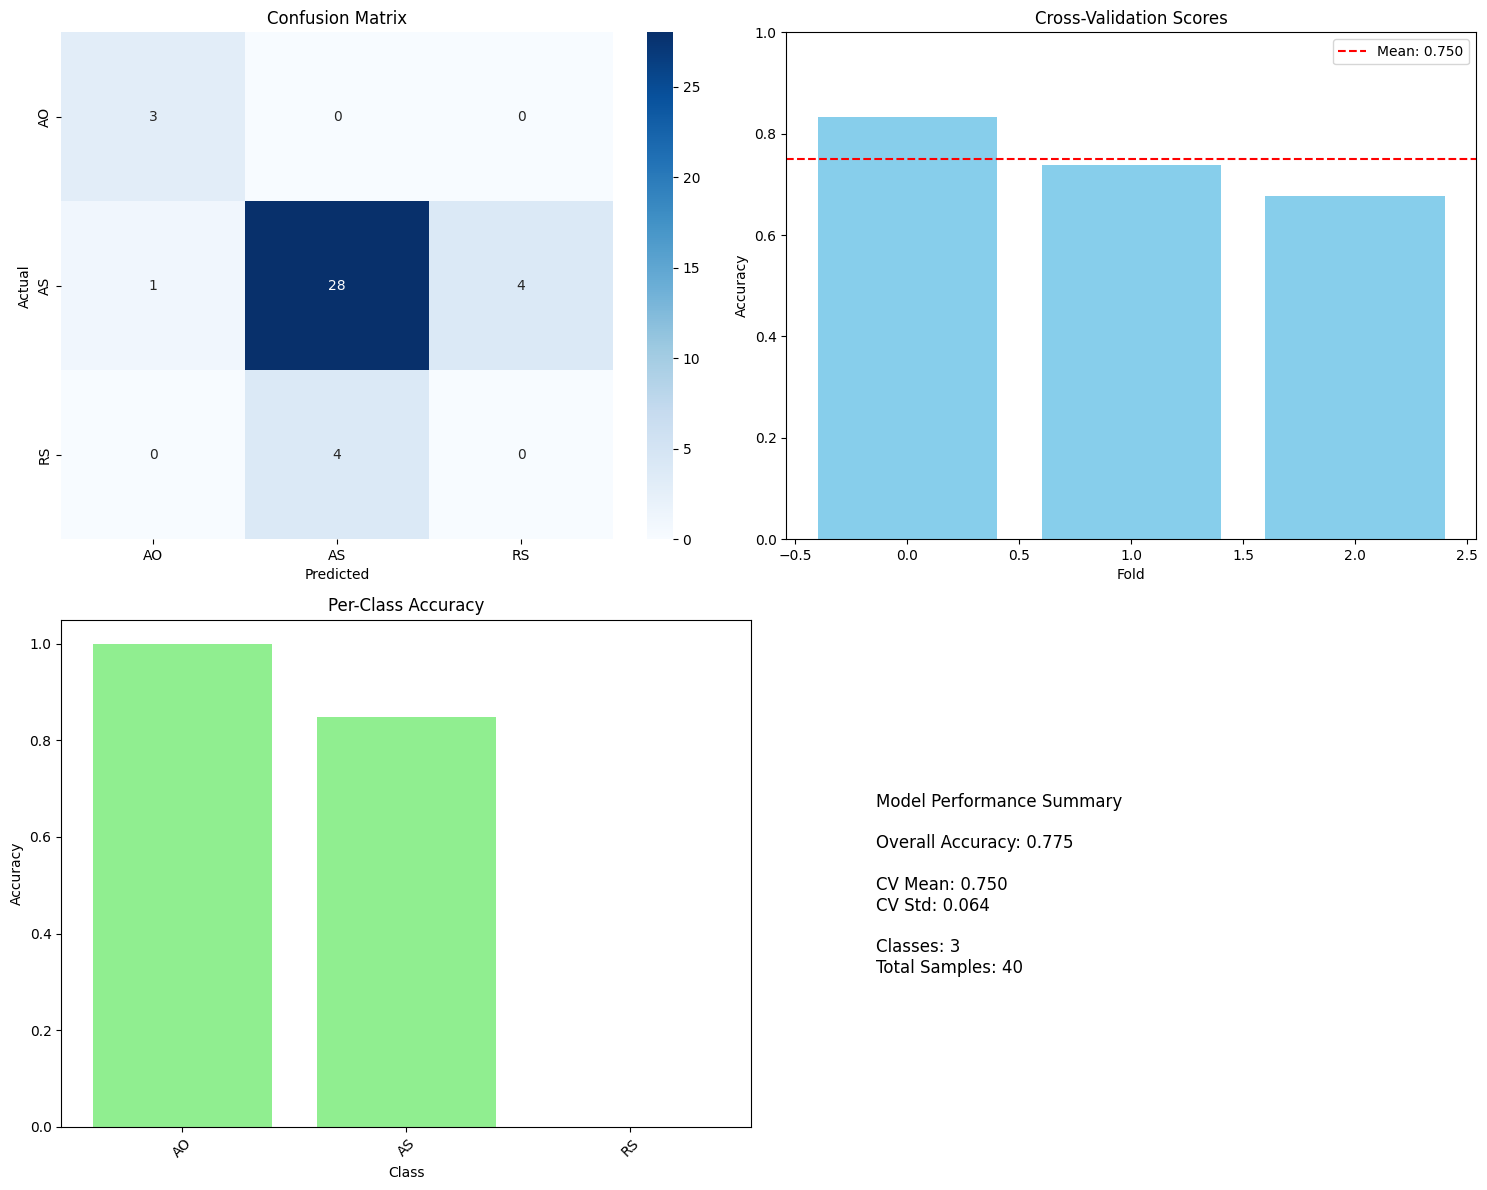


5. Testing individual predictions...

Example 1:
Target: I think Jack should tell on Thomas
Source: because it's the right thing to do
Predicted: AS (confidence: 0.754)
Expected: AS
Correct: ✓

Example 2:
Target: Students should work independently
Source: because the teacher said to work alone
Predicted: RS (confidence: 0.646)
Expected: RS
Correct: ✓

Example 3:
Target: Thomas shouldn't have cheated
Source: some people might disagree with this view
Predicted: RS (confidence: 0.392)
Expected: AO
Correct: ✗

6. Essay-level analysis...

Analysis for E01:
  predicted_label actual_label  confidence  correct
0              AS           AS    0.753945     True
1              RS           AS    0.498392    False
2              AO           AO    0.640573     True
3              AS           AS    0.505887     True
4              AS           AS    0.555015     True
Essay-level accuracy: 0.938

CLASSIFIER READY FOR USE!

🎉 SUCCESS! Your RFM classifier is ready to use.

To make predictions on n

In [2]:
# RFM Argument Relationship Classifier - Google Colab Version
# Rational Force Model for Automated Essay Scoring

# Install required packages
!pip install scikit-learn pandas numpy matplotlib seaborn nltk openpyxl

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from google.colab import files
import io

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Upload your Excel file
print("Please upload your 'ideaunits_data 1.xlsx' file:")
uploaded = files.upload()

# Load the data
filename = list(uploaded.keys())[0]
df = pd.read_excel(io.BytesIO(uploaded[filename]))

print(f"Data loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

# Check label distribution
print(f"\nLabel distribution:")
print(df['label'].value_counts())

class RFMClassifier:
    """
    Rational Force Model (RFM) Classifier for Automated Essay Scoring

    Classifies proposition relationships in argumentative essays:
    - AS (Acceptability Support): Increases another proposition's acceptability
    - AO (Acceptability Objection): Decreases another proposition's acceptability
    - RS (Relevance Support): Increases another proposition's relevance
    - RO (Relevance Objection): Decreases another proposition's relevance
    """

    def __init__(self, model_type='logistic', max_features=5000, ngram_range=(1, 2)):
        self.model_type = model_type
        self.max_features = max_features
        self.ngram_range = ngram_range
        self.label_encoder = LabelEncoder()
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.pipeline = None
        self.feature_names = None

    def preprocess_text(self, text):
        """Clean and preprocess text data"""
        if pd.isna(text) or text is None:
            return ""

        text = str(text).lower()
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)

        tokens = word_tokenize(text)
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens
                 if token not in self.stop_words and len(token) > 2]

        return ' '.join(tokens)

    def create_features(self, target_text, source_text):
        """Create combined feature representation"""
        target_clean = self.preprocess_text(target_text)
        source_clean = self.preprocess_text(source_text)
        combined_text = f"{target_clean} [SEP] {source_clean}"
        return combined_text

    def prepare_data(self, df):
        """Prepare data for training/prediction"""
        # Remove rows with undefined/missing labels
        df_clean = df.dropna(subset=['label']).copy()
        df_clean = df_clean[df_clean['label'].notna()]
        df_clean = df_clean[df_clean['label'] != '']

        # Create combined features
        df_clean['combined_text'] = df_clean.apply(
            lambda row: self.create_features(row['target_idea'], row['source_idea']),
            axis=1
        )

        # Filter out empty texts
        df_clean = df_clean[df_clean['combined_text'].str.len() > 0]

        print(f"Data preparation complete. Clean samples: {len(df_clean)}")
        print(f"Label distribution after cleaning:")
        print(df_clean['label'].value_counts())

        return df_clean

    def build_model(self):
        """Build the classification pipeline"""
        vectorizer = TfidfVectorizer(
            max_features=self.max_features,
            ngram_range=self.ngram_range,
            stop_words='english',
            lowercase=True,
            min_df=2,
            max_df=0.95
        )

        if self.model_type == 'logistic':
            classifier = LogisticRegression(
                random_state=42,
                max_iter=1000,
                class_weight='balanced'
            )
        elif self.model_type == 'svm':
            classifier = SVC(
                random_state=42,
                kernel='rbf',
                class_weight='balanced',
                probability=True  # Enable probability prediction
            )
        elif self.model_type == 'random_forest':
            classifier = RandomForestClassifier(
                random_state=42,
                n_estimators=100,
                class_weight='balanced'
            )

        self.pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])

        return self.pipeline

    def train(self, df):
        """Train the model"""
        print("Preparing data...")
        df_clean = self.prepare_data(df)

        if len(df_clean) < 10:
            raise ValueError("Not enough clean data for training!")

        X = df_clean['combined_text']
        y = df_clean['label']

        # Encode labels
        y_encoded = self.label_encoder.fit_transform(y)

        # Build and train model
        self.build_model()
        print(f"Training {self.model_type} classifier...")
        self.pipeline.fit(X, y_encoded)

        print("Training completed!")
        return self

    def evaluate(self, df, test_size=0.2, cv_folds=5):
        """Evaluate model performance"""
        df_clean = self.prepare_data(df)
        X = df_clean['combined_text']
        y = self.label_encoder.transform(df_clean['label'])

        # Adjust test_size and cv_folds for small datasets
        n_samples = len(X)
        if n_samples < 20:
            test_size = 0.3
            cv_folds = min(3, n_samples)

        # Train-test split
        if test_size > 0:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=42,
                stratify=y if len(np.unique(y)) > 1 else None
            )

            self.pipeline.fit(X_train, y_train)
            y_pred = self.pipeline.predict(X_test)

            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy: {accuracy:.3f}")

            target_names = self.label_encoder.classes_
            report = classification_report(
                y_test, y_pred,
                target_names=target_names,
                zero_division=0
            )
            print("\nClassification Report:")
            print(report)

            cm = confusion_matrix(y_test, y_pred)
        else:
            # If dataset too small for train-test split
            self.pipeline.fit(X, y)
            accuracy = 1.0
            report = "Dataset too small for train-test split"
            cm = np.array([[1]])
            target_names = self.label_encoder.classes_

        # Cross-validation
        if cv_folds > 1 and len(np.unique(y)) > 1:
            try:
                cv_scores = cross_val_score(
                    self.pipeline, X, y,
                    cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
                    scoring='accuracy'
                )
                print(f"\nCross-validation scores: {cv_scores}")
                print(f"CV Mean: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
            except Exception as e:
                print(f"Cross-validation failed: {e}")
                cv_scores = np.array([accuracy])
        else:
            cv_scores = np.array([accuracy])

        return {
            'accuracy': accuracy,
            'classification_report': report,
            'confusion_matrix': cm,
            'cv_scores': cv_scores,
            'target_names': target_names
        }

    def predict(self, target_text, source_text):
        """Predict relationship type for a single pair"""
        if self.pipeline is None:
            raise ValueError("Model not trained yet. Call train() first.")

        combined_text = self.create_features(target_text, source_text)
        prediction_encoded = self.pipeline.predict([combined_text])[0]
        prediction_proba = self.pipeline.predict_proba([combined_text])[0]

        prediction = self.label_encoder.inverse_transform([prediction_encoded])[0]

        classes = self.label_encoder.classes_
        proba_dict = dict(zip(classes, prediction_proba))

        return {
            'prediction': prediction,
            'confidence': prediction_proba.max(),
            'probabilities': proba_dict
        }

    def analyze_essay(self, essay_id, df):
        """Analyze all proposition pairs in a specific essay"""
        essay_data = df[df['essay_id'] == essay_id].copy()

        if len(essay_data) == 0:
            print(f"No data found for essay {essay_id}")
            return None

        results = []
        for _, row in essay_data.iterrows():
            try:
                pred = self.predict(row['target_idea'], row['source_idea'])
                results.append({
                    'target_idea': row['target_idea'],
                    'source_idea': row['source_idea'],
                    'actual_label': row.get('label', 'Unknown'),
                    'predicted_label': pred['prediction'],
                    'confidence': pred['confidence'],
                    'correct': row.get('label') == pred['prediction'] if pd.notna(row.get('label')) else None
                })
            except Exception as e:
                print(f"Error predicting for row: {e}")
                continue

        return pd.DataFrame(results)

def visualize_results(results, save_plots=False):
    """Create visualizations for model results"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Confusion Matrix
    cm = results['confusion_matrix']
    target_names = results['target_names']

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names, ax=axes[0,0])
    axes[0,0].set_title('Confusion Matrix')
    axes[0,0].set_xlabel('Predicted')
    axes[0,0].set_ylabel('Actual')

    # CV Scores
    cv_scores = results['cv_scores']
    axes[0,1].bar(range(len(cv_scores)), cv_scores, color='skyblue')
    axes[0,1].axhline(y=cv_scores.mean(), color='red', linestyle='--',
                      label=f'Mean: {cv_scores.mean():.3f}')
    axes[0,1].set_title('Cross-Validation Scores')
    axes[0,1].set_xlabel('Fold')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()
    axes[0,1].set_ylim(0, 1)

    # Accuracy by Class (if we can calculate it)
    try:
        # Calculate per-class accuracy from confusion matrix
        class_acc = cm.diagonal() / cm.sum(axis=1)
        axes[1,0].bar(target_names, class_acc, color='lightgreen')
        axes[1,0].set_title('Per-Class Accuracy')
        axes[1,0].set_xlabel('Class')
        axes[1,0].set_ylabel('Accuracy')
        axes[1,0].tick_params(axis='x', rotation=45)
    except:
        axes[1,0].text(0.5, 0.5, 'Per-class accuracy\nnot available',
                       ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1,0].set_title('Per-Class Accuracy')

    # Model Performance Summary
    axes[1,1].axis('off')
    summary_text = f"""
    Model Performance Summary

    Overall Accuracy: {results['accuracy']:.3f}

    CV Mean: {cv_scores.mean():.3f}
    CV Std: {cv_scores.std():.3f}

    Classes: {len(target_names)}
    Total Samples: {cm.sum()}
    """
    axes[1,1].text(0.1, 0.7, summary_text, fontsize=12,
                   verticalalignment='top', transform=axes[1,1].transAxes)

    plt.tight_layout()
    if save_plots:
        plt.savefig('rfm_classifier_results.png', dpi=300, bbox_inches='tight')
    plt.show()

def demonstrate_classifier(df):
    """Main demonstration function"""

    print("="*60)
    print("RFM ARGUMENT RELATIONSHIP CLASSIFIER")
    print("="*60)

    # Initialize classifier
    print("\n1. Initializing classifier...")
    classifier = RFMClassifier(model_type='logistic', max_features=1000, ngram_range=(1, 2))

    # Train the model
    print("\n2. Training model...")
    try:
        classifier.train(df)
        print("✓ Training completed successfully!")
    except Exception as e:
        print(f"✗ Training failed: {e}")
        return None, None

    # Evaluate the model
    print("\n3. Evaluating model...")
    try:
        results = classifier.evaluate(df, test_size=0.2, cv_folds=3)
        print("✓ Evaluation completed!")
    except Exception as e:
        print(f"✗ Evaluation failed: {e}")
        return classifier, None

    # Visualize results
    print("\n4. Creating visualizations...")
    try:
        visualize_results(results)
    except Exception as e:
        print(f"Warning: Visualization failed: {e}")

    # Test individual predictions
    print("\n5. Testing individual predictions...")

    # Use actual examples from the dataset
    test_examples = [
        {
            'target': "I think Jack should tell on Thomas",
            'source': "because it's the right thing to do",
            'expected': 'AS'
        },
        {
            'target': "Students should work independently",
            'source': "because the teacher said to work alone",
            'expected': 'RS'
        },
        {
            'target': "Thomas shouldn't have cheated",
            'source': "some people might disagree with this view",
            'expected': 'AO'
        }
    ]

    for i, example in enumerate(test_examples, 1):
        try:
            pred = classifier.predict(example['target'], example['source'])
            print(f"\nExample {i}:")
            print(f"Target: {example['target']}")
            print(f"Source: {example['source']}")
            print(f"Predicted: {pred['prediction']} (confidence: {pred['confidence']:.3f})")
            if 'expected' in example:
                print(f"Expected: {example['expected']}")
                print(f"Correct: {'✓' if pred['prediction'] == example['expected'] else '✗'}")
        except Exception as e:
            print(f"Error in prediction {i}: {e}")

    # Analyze a specific essay
    print("\n6. Essay-level analysis...")
    try:
        essay_ids = df['essay_id'].unique()
        if len(essay_ids) > 0:
            sample_essay = essay_ids[0]
            essay_analysis = classifier.analyze_essay(sample_essay, df)
            if essay_analysis is not None and len(essay_analysis) > 0:
                print(f"\nAnalysis for {sample_essay}:")
                print(essay_analysis[['predicted_label', 'actual_label', 'confidence', 'correct']].head())

                if 'correct' in essay_analysis.columns:
                    accuracy = essay_analysis['correct'].mean()
                    print(f"Essay-level accuracy: {accuracy:.3f}")
    except Exception as e:
        print(f"Essay analysis failed: {e}")

    print("\n" + "="*60)
    print("CLASSIFIER READY FOR USE!")
    print("="*60)

    return classifier, results

# Interactive prediction function
def interactive_predict(classifier):
    """Allow users to input their own proposition pairs"""
    print("\n" + "="*50)
    print("INTERACTIVE PREDICTION MODE")
    print("="*50)
    print("Enter proposition pairs to classify their relationship.")
    print("Type 'quit' to exit.\n")

    while True:
        try:
            target = input("Enter target proposition: ").strip()
            if target.lower() == 'quit':
                break

            source = input("Enter source proposition: ").strip()
            if source.lower() == 'quit':
                break

            if target and source:
                pred = classifier.predict(target, source)
                print(f"\nPrediction: {pred['prediction']}")
                print(f"Confidence: {pred['confidence']:.3f}")
                print("All probabilities:")
                for label, prob in sorted(pred['probabilities'].items(),
                                        key=lambda x: x[1], reverse=True):
                    print(f"  {label}: {prob:.3f}")
                print("-" * 30)
            else:
                print("Please enter both target and source propositions.")

        except KeyboardInterrupt:
            break
        except Exception as e:
            print(f"Error: {e}")

    print("Exiting interactive mode.")

# Run the main demonstration
print("Starting RFM Classifier demonstration...")
classifier, results = demonstrate_classifier(df)

if classifier is not None:
    print(f"\n🎉 SUCCESS! Your RFM classifier is ready to use.")
    print(f"\nTo make predictions on new data:")
    print(f"prediction = classifier.predict('target text', 'source text')")
    print(f"\nTo analyze a specific essay:")
    print(f"analysis = classifier.analyze_essay('essay_id', df)")

    # Uncomment the next line to enable interactive prediction mode
    # interactive_predict(classifier)
else:
    print("❌ Classifier initialization failed. Please check your data and try again.")

# Save the trained model (optional)
import pickle

def save_model(classifier, filename='rfm_classifier.pkl'):
    """Save the trained classifier"""
    try:
        with open(filename, 'wb') as f:
            pickle.dump(classifier, f)
        print(f"Model saved as {filename}")
    except Exception as e:
        print(f"Failed to save model: {e}")

def load_model(filename='rfm_classifier.pkl'):
    """Load a saved classifier"""
    try:
        with open(filename, 'rb') as f:
            classifier = pickle.load(f)
        print(f"Model loaded from {filename}")
        return classifier
    except Exception as e:
        print(f"Failed to load model: {e}")
        return None

# Uncomment to save the trained model
if classifier is not None:
    save_model(classifier, 'rfm_classifier.pkl')

print("\n🚀 All done! Your RFM classifier is ready for research use.")